# Unsupervised Learning with Scikit-Learn
Now we'll work through an example of _unsupervised learning_. Recall unsupervised learning deals with situations in which we have no information on what the labels are, i.e. we're given only the inputs in our dataset. Unsupervised learning is essentially an umbrella term that covers three different tasks. One task is _dimensionality reduction_, where we seek to reduce the dimension of our dataset. The reasons we may wish to do something like this include reducing the memory load of the data, trying to eliminate noise from the data, or trying to visualize high-dimensional data. Another task of unsupervised learning is _clustering_. Clustering involves trying to find underlying patterns in the input data, and using these patterns to infer what our unknown labels are. The last task of unsupervised learning is _density estimation_, i.e. inferring what the underlying joint distribution of the data is.

In this example we use Scikit-Learn illustrate the first two tasks on a real dataset. To begin we load some Python libraries we'll need. As always we need `numpy`, `matplotlib`, and various classes from `sklearn`. We also use the `pandas` library, a very useful library for data processing, to load in the data from an internet `csv` file. The `scipy` library is used to perform hierarchical clustering later on since it is able to show tree plots. As usual, we also set a random seed to allow for replication of our results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import preprocessing
np.random.seed(42)

Next, we define several support functions that will be used. The first function loads in our input data and returns it as the usual array. The rest generate various plots that we'll talk about in more detail.

In [2]:
def get_data(dataset):
    if dataset==1:
        names = ['x'+str(i) for i in range(1,3+1)]
        df = pd.read_csv('http://www.apps.stat.vt.edu/leman/VTCourses/ClusterSet1.txt',
                         delim_whitespace=True,header=None,names=names)
    elif dataset==2:
        names = ['x'+str(i) for i in range(1,50+1)]
        df = pd.read_csv('http://www.apps.stat.vt.edu/leman/VTCourses/ClusterSet2.txt',
                         delim_whitespace=True,header=None,names=names)
    X = preprocessing.scale(df.values)
    return X
    
def pca_plot(X):
    N = min(X.shape[1],20)
    pca = PCA(n_components=N)
    pca.fit(X)
    plt.plot(range(1,N+1),pca.explained_variance_ratio_)
    plt.xlim(0,N+1)
    plt.xticks(np.arange(1,N+1))
    plt.xlabel('principal components')
    plt.ylabel('% of variance explained')
    plt.show()

def loss_plot(X,model_type='k-means',max_clusters=10):
    num_clusters = np.arange(1,max_clusters+1)
    scores = []
    for num in num_clusters:
        if model_type=='k-means':
            model = KMeans(n_clusters=num)
        elif model_type=='GMM':
            model = GaussianMixture(n_components=num, covariance_type='full')
        elif model_type=='BGMM':
            model = BayesianGaussianMixture(n_components=num, covariance_type='full')
        model.fit(X)
        scores += [-model.score(X)]        
    plt.plot(np.arange(1,max_clusters+1),scores)
    plt.xlim(0,max_clusters)
    plt.xticks(np.arange(1,max_clusters+1))
    plt.xlabel('number of clusters')
    plt.ylabel('loss')
    plt.title(model_type+' loss plot')
    plt.show()

def plot_clusters(X,y,model_type):
    num_clusters = np.unique(y).shape[0]
    _,ax = plt.subplots(1,1)
    for i in range(num_clusters):
        if not np.any(y == i):
            continue
        ax.scatter(X[y == i, 0], X[y == i, 1], .8, cmap='Dark2')
    ax.set_title(model_type+': '+str(num_clusters)+' clusters')
    plt.show()

Now we get to the machine learning. The first thing we will do is dimensionality reduction on our data. The specific reduction algorithm we use is _Principal Components Analysis_, or PCA. This is by far the most widely known reduction algorithm out there. It acts by finding the directions in the feature space that preserve the most variation in the data, ranking those directions in order of importance. In doing dimensionality reduction, or task is to find how many of those directions we should keep to preserve "enough" structure in the data to make us happy. We can do this by plotting the explained variance ratio, and picking enough dimensions to maintain a specified level of variance (usually 90% or above). 

Based on the plot below, it seems like we should perhaps pick 10 components since that's where the "elbow" in the plot occurs. But in our case, we take only the top 2 dimensions, just so we can easily visualize the data. We also confirm that, in fact, `X_pca` indeed reduces the dimension of the feature space from 50 to 2.

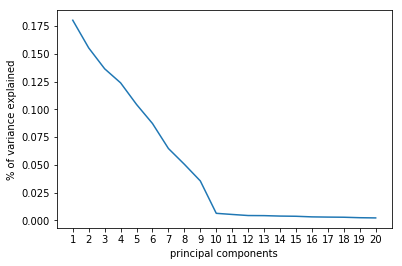

X_pca shape:  (1000, 2)
X shape:  (1000, 50)


In [6]:
X = get_data(2)

pca_plot(X)

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

print('X_pca shape: ',X_pca.shape)
print('X shape: ',X.shape)

A plot of our chosen 2D PCA projection of the data is shown below. You can think of this in some sense as the best linear projection of the data on a 2D space.

In [ ]:
plt.scatter(X_pca[:,0],X_pca[:,1])
plt.title('PCA with 2 components')
plt.show()

Now let's do some clustering on our new 2-dimensional dataset. The most popular clustering algorithm is _k-means clustering_, probably the simplest clustering technique out there. k-means clustering acts by using an interative procedure to find the $k$ best local averages in the data. These _centroids_ are then used to determine what clusters the algorithm comes up with. Given a point, to determine what cluster it's in you find its closest centroid and give it the label of that centroid. Of course, the first question you should ask yourself is what value of $k$ you should choose. The algorithm doesn't do this for you, you have to specify it. This is perhaps the algorithm's biggest weakness, because we often don't know how many clusters there really should be in the data. 

We can find a good value of $k$ similar to what we did with PCA above, by looking for the "elbow" in the plot of the loss. It's hard to spot an obvious "elbow" in the plot, which means the clusters aren't necessarily all that "sharp" to find using k-means. Nevertheless, taking $k=6$ seems like a reasonable choice to start with.

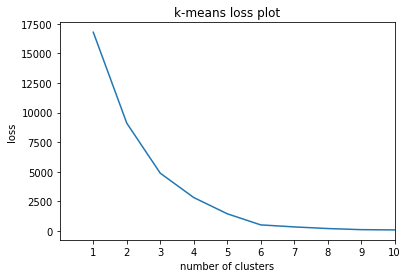

In [7]:
loss_plot(X_pca,model_type='k-means')

Now that we have a decent value for $k$, we can set up our clustering model. Notice the API for `KMeans` is very similar to the ones we saw before for supervised learning, we instantiate the model and then fit it on the data. Since this is an unsupervised model, we only fit it on the input data `X_pca`. Once we've done that, we can generate the cluster labels by calling the `.predict` method. We then use this to plot what the clusters look like on our 2D projected data. How does it look? Did we choose the right number of clusters? Feel free to vary the value of $k$ by changing the `n_clusters` parameter.

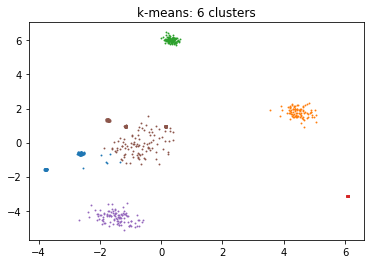

In [8]:
model = KMeans(n_clusters=6)
model.fit(X_pca)
y = model.predict(X_pca)    
plot_clusters(X_pca,y,'k-means')

One reason the above clusters don't look like they "should" is because k-means is a simple clustering model. It doesn't take shapes or densities of clusters into account very well. K-means is used in practice because it is _fast_, not because it's the best at finding clusters. In fact, k-means isn't guaranteed to give you the same clusters each time you run the model. It's not even guaranteed to converge at all!

One simple extension to k-means we can try is the _Gaussian Mixture Model_. This is an extension of k-means that allows clusters to be elliptical instead of just spherical. It is also a probability model, meaning it can be used for anomaly detection as well (classify low-probability points as anomalies). 

Here the GMM clusters don't have a clear "elbow" either. We just take `n_clusters` to be 10 and plot the results. Do the clusters look any better?

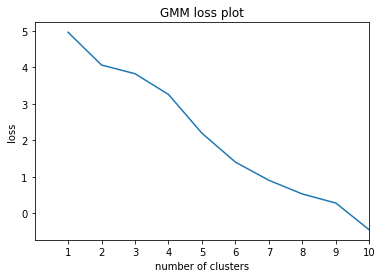

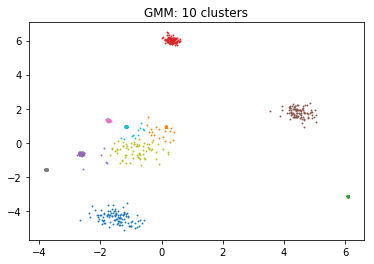

In [15]:
loss_plot(X_pca,model_type='GMM')    
model = KMeans(n_clusters=10)
model.fit(X_pca)
y = model.predict(X_pca)    
plot_clusters(X_pca,y,'GMM')

A slight varient on the GMM is the _Bayesian Gaussian Mixture Model_, aka _Variational Bayes_. The main difference between GMM and BGMM is that (in typical Bayesian fashion) a prior is defined on the probability model. A plot with 10 clusters is shown below. Any improvement?

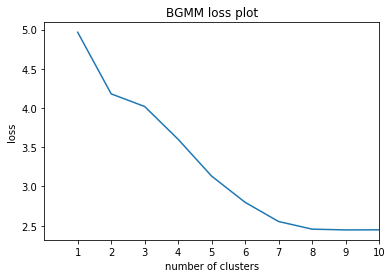

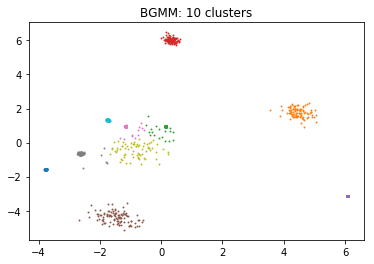

In [14]:
loss_plot(X_pca,model_type='BGMM')    
model = KMeans(n_clusters=10)
model.fit(X_pca)
y = model.predict(X_pca)    
plot_clusters(X_pca,y,'BGMM')

Now we quickly look at examples of non-parametric clustering models. One tree-based method is _hierarchical clustering_, aka _agglomerative clustering_. HM works by first starting with each point having its own cluster, and then steadily assembles them together to create super-clusters around them. It does this over and over until all points lie in one cluster. Thus, HM can generate clusters within clusters, which is sometimes useful. The HM process can be visualized with a _dendrogram_, which shows where it adds new clusters (read bottom-up).

We first plot the dendrogram using the `scipy` library, as `sklearn` doesn't have a built in function for this as far as I could find. We then define an HM model and show a plot of the model with 5 clusters below.

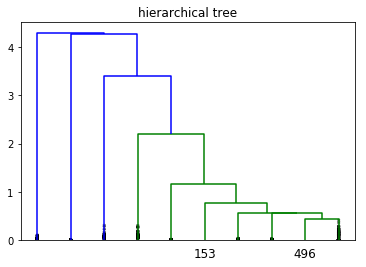

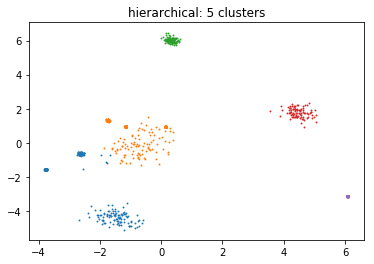

In [13]:
Z = linkage(X_pca,method='single')
plt.figure()
dn = dendrogram(Z,p=10,truncate_mode='lastp',show_contracted=True,show_leaf_counts=False)
plt.title('hierarchical tree')
plt.show()

model = AgglomerativeClustering(n_clusters=5)
model.fit(X_pca)
y = model.labels_  
plot_clusters(X_pca,y,'hierarchical')
plt.show()

We finish up by showing the `DBSCAN` clustering algorithm. DBSCAN works by looking for regions of high density (number of points in a given radius) and classifying them into clusters. One great thing about DBSCAN is you don't have to tell it how many clusters to find, it finds them itself. Partly because of this, DBSCAN is widely used in practice to generate robust clusters. It's great for anomaly detection as well (classify points in areas of low density as anomalies).

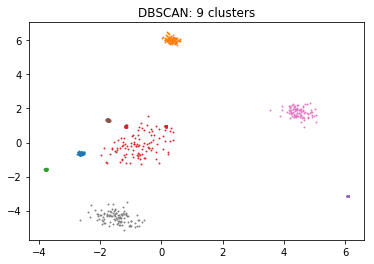

In [12]:
model = DBSCAN()
model.fit(X_pca)
y = model.labels_
plot_clusters(X_pca,y,'DBSCAN')
plt.show()